In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("=== CNN COMPLETA PARA CLASSIFICAÇÃO CÃES vs GATOS ===\n")

=== CNN COMPLETA PARA CLASSIFICAÇÃO CÃES vs GATOS ===



In [2]:
# 1. CONFIGURAÇÃO INICIAL
def setup_environment():
    """Configura o ambiente e verifica dependências"""
    print("🔧 Configurando ambiente...")

    # Verificar versões
    print(f"TensorFlow version: {tf.__version__}")
    print(f"Keras version: {keras.__version__}")

    # Configurar para usar GPU se disponível
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"✅ GPU detectada: {len(gpus)} dispositivo(s)")
        except RuntimeError as e:
            print(f"❌ Erro na configuração da GPU: {e}")
    else:
        print("ℹ️  GPU não detectada, usando CPU")

setup_environment()

🔧 Configurando ambiente...
TensorFlow version: 2.19.0
Keras version: 3.10.0
ℹ️  GPU não detectada, usando CPU


In [3]:
# 2. DOWNLOAD E PREPARAÇÃO DO DATASET
def load_dogs_vs_cats_dataset():
    """
    Carrega o dataset Dogs vs Cats do TensorFlow Datasets
    """
    print("\n📦 CARREGANDO DATASET DOGS VS CATS...")

    try:
        # Carregar dataset
        (raw_train, raw_validation), dataset_info = tfds.load(
            'cats_vs_dogs',
            split=['train[:80%]', 'train[80%:]'],
            with_info=True,
            as_supervised=True,
            shuffle_files=True
        )

        print("✅ Dataset carregado com sucesso!")
        print(f"📊 Estatísticas do dataset:")
        print(f"   - Total de imagens: {dataset_info.splits['train'].num_examples}")
        print(f"   - Imagens de treino: {len(raw_train)}")
        print(f"   - Imagens de validação: {len(raw_validation)}")
        print(f"   - Classes: {dataset_info.features['label'].names}")
        print(f"   - Formato das imagens: {dataset_info.features['image'].shape}")

        return raw_train, raw_validation, dataset_info

    except Exception as e:
        print(f"❌ Erro ao carregar dataset: {e}")
        print("📝 Criando dataset de demonstração...")
        return create_demo_dataset()

def create_demo_dataset():
    """Cria dataset de demonstração caso o download falhe"""
    print("🎨 Criando dataset de demonstração...")

    # Usar um dataset pequeno incluso no TFDS para demonstração
    (raw_train, raw_validation), dataset_info = tfds.load(
        'cifar10',
        split=['train[:1000]', 'test[:200]'],
        with_info=True,
        as_supervised=True
    )

    print("💡 Usando CIFAR-10 como demonstração (substitua por Dogs vs Cats depois)")
    return raw_train, raw_validation, dataset_info

def preprocess_dataset(raw_train, raw_validation, img_size=(150, 150), batch_size=20):
    """
    Pré-processa o dataset para treinamento
    """
    print(f"\n🔧 PRÉ-PROCESSANDO DATASET...")
    print(f"   - Tamanho da imagem: {img_size}")
    print(f"   - Batch size: {batch_size}")

    # Função de pré-processamento
    def preprocess_image(image, label):
        # Redimensionar para o tamanho desejado
        image = tf.image.resize(image, img_size)
        # Converter para float e normalizar [0, 1]
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    # Aplicar pré-processamento
    train_dataset = raw_train.map(preprocess_image)
    validation_dataset = raw_validation.map(preprocess_image)

    # Configurar batches e performance
    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, validation_dataset

In [4]:
# 3. DEFINIÇÃO DA ARQUITETURA DA CNN
def create_cnn_model(input_shape=(150, 150, 3)):
    """
    Cria a arquitetura da CNN (equivalente ao código R original)
    """
    print("\n🏗️  CRIANDO ARQUITETURA DA CNN...")

    model = keras.Sequential([
        # Bloco 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Bloco 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Bloco 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Bloco 4
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Classificador
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),  # Adicionado para regularização
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    return model

def compile_model(model, learning_rate=1e-4):
    """
    Compila o modelo com os parâmetros do código R
    """
    print("🔨 COMPILANDO MODELO...")

    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    print("✅ Modelo compilado com:")
    print(f"   - Loss: binary_crossentropy")
    print(f"   - Optimizer: RMSprop (lr={learning_rate})")
    print(f"   - Metrics: accuracy")

    return model

In [5]:
# 4. CALLBACKS E CONFIGURAÇÃO DE TREINAMENTO
def setup_callbacks():
    """
    Configura os callbacks para treinamento
    """
    print("\n⏰ CONFIGURANDO CALLBACKS...")

    callbacks_list = [
        # Early Stopping
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),

        # Reduce Learning Rate on Plateau
        callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=10,
            mode='max',
            verbose=1
        ),

        # Model Checkpoint
        callbacks.ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),

        # TensorBoard (opcional)
        # callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)
    ]

    print("✅ Callbacks configurados:")
    print("   - Early Stopping (paciência: 10)")
    print("   - Reduce LR on Plateau (fator: 0.5)")
    print("   - Model Checkpoint")

    return callbacks_list

In [6]:
# 5. TREINAMENTO DO MODELO
def train_model(model, train_dataset, validation_dataset, callbacks_list, epochs=30):
    """
    Executa o treinamento do modelo
    """
    print("\n🎯 INICIANDO TREINAMENTO...")
    print(f"   - Épocas: {epochs}")
    print(f"   - Batch size: {train_dataset.element_spec[0].shape[0]}")

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=callbacks_list,
        verbose=1
    )

    print("✅ Treinamento concluído!")
    return history

In [7]:
# 6. VISUALIZAÇÃO DOS RESULTADOS
def plot_training_history(history):
    """
    Plota o histórico de treinamento
    """
    print("\n📊 VISUALIZANDO RESULTADOS DO TREINAMENTO...")

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Loss durante o Treinamento', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax2.set_title('Accuracy durante o Treinamento', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Learning Rate
    if 'lr' in history.history:
        ax3.plot(history.history['lr'], linewidth=2, color='red')
        ax3.set_title('Learning Rate durante o Treinamento', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Época')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)

    # Métricas finais
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])

    metrics_data = {
        'Métrica': ['Treino Final', 'Validação Final', 'Melhor Validação'],
        'Accuracy': [final_train_acc, final_val_acc, best_val_acc]
    }

    metrics_df = pd.DataFrame(metrics_data)
    ax4.axis('off')
    table = ax4.table(cellText=metrics_df.values,
                     colLabels=metrics_df.columns,
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax4.set_title('Métricas Finais', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return final_train_acc, final_val_acc, best_val_acc

def plot_sample_predictions(model, dataset, dataset_info, num_samples=8):
    """
    Plota amostras com as predições do modelo
    """
    print("\n🔍 VISUALIZANDO PREDIÇÕES EM AMOSTRAS...")

    # Pegar um batch do dataset
    for images, labels in dataset.take(1):
        # Fazer predições
        predictions = model.predict(images, verbose=0)
        predicted_classes = (predictions > 0.5).astype(int).flatten()

        # Plotar amostras
        fig, axes = plt.subplots(2, 4, figsize=(15, 8))
        axes = axes.ravel()

        for i in range(min(num_samples, len(images))):
            # Obter classe verdadeira e predita
            true_label = "Cachorro" if labels[i].numpy() == 1 else "Gato"
            pred_label = "Cachorro" if predicted_classes[i] == 1 else "Gato"
            confidence = predictions[i][0]

            # Plotar imagem
            axes[i].imshow(images[i].numpy())
            axes[i].set_title(f'Verd: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                            fontsize=10, fontweight='bold')

            # Colorir baseado na acurácia
            color = 'green' if true_label == pred_label else 'red'
            axes[i].set_xlabel(f'Accuracy: {color}', color=color)
            axes[i].set_xticks([])
            axes[i].set_yticks([])

        plt.tight_layout()
        plt.show()

        break

In [8]:
# 7. AVALIAÇÃO DETALHADA DO MODELO
def evaluate_model(model, validation_dataset):
    """
    Avaliação detalhada do modelo
    """
    print("\n📈 AVALIAÇÃO DETALHADA DO MODELO...")

    # Avaliação básica
    evaluation = model.evaluate(validation_dataset, verbose=0)
    print(f"📊 Métricas de avaliação:")
    print(f"   - Loss: {evaluation[0]:.4f}")
    print(f"   - Accuracy: {evaluation[1]:.4f}")

    # Coletar todas as predições para métricas detalhadas
    y_true = []
    y_pred = []
    y_pred_proba = []

    for images, labels in validation_dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend((predictions > 0.5).astype(int).flatten())
        y_pred_proba.extend(predictions.flatten())

    # Métricas de classificação
    print("\n📋 RELATÓRIO DE CLASSIFICAÇÃO:")
    print(classification_report(y_true, y_pred, target_names=['Gato', 'Cachorro']))

    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Gato', 'Cachorro'],
                yticklabels=['Gato', 'Cachorro'])
    plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()

    return evaluation

In [9]:
# 8. FUNÇÃO PARA CLASSIFICAR NOVAS IMAGENS
def classify_new_image(model, image_path, img_size=(150, 150)):
    """
    Classifica uma nova imagem usando o modelo treinado
    """
    try:
        # Carregar e pré-processar a imagem
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, img_size)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.expand_dims(image, axis=0)  # Adicionar dimensão do batch

        # Fazer predição
        prediction = model.predict(image, verbose=0)
        probability = prediction[0][0]
        class_name = "CACHORRO" if probability > 0.5 else "GATO"
        confidence = probability if probability > 0.5 else 1 - probability

        # Exibir resultados
        plt.figure(figsize=(8, 6))
        plt.imshow(image[0])
        plt.axis('off')
        plt.title(f'Classificação: {class_name}\nConfiança: {confidence:.2%}',
                 fontsize=16, fontweight='bold', pad=20)
        plt.show()

        print(f"\n🎯 RESULTADO DA CLASSIFICAÇÃO:")
        print(f"   - Arquivo: {os.path.basename(image_path)}")
        print(f"   - Probabilidade de ser cachorro: {probability:.4f}")
        print(f"   - Classe predita: {class_name}")
        print(f"   - Confiança: {confidence:.2%}")

        return probability, class_name

    except Exception as e:
        print(f"❌ Erro ao classificar imagem: {e}")
        return None, None

In [10]:
# 9. FLUXO PRINCIPAL DE EXECUÇÃO
def main():
    """
    Fluxo principal do programa
    """
    print("🚀 INICIANDO EXECUÇÃO DO PROGRAMA...\n")

    # 1. Carregar dataset
    raw_train, raw_validation, dataset_info = load_dogs_vs_cats_dataset()

    # 2. Pré-processar dados
    train_dataset, validation_dataset = preprocess_dataset(raw_train, raw_validation)

    # 3. Criar modelo
    model = create_cnn_model()
    model = compile_model(model)

    # 4. Configurar callbacks
    callbacks_list = setup_callbacks()

    # 5. Treinar modelo
    history = train_model(model, train_dataset, validation_dataset, callbacks_list, epochs=30)

    # 6. Visualizar resultados
    final_train_acc, final_val_acc, best_val_acc = plot_training_history(history)

    # 7. Avaliar modelo
    evaluation = evaluate_model(model, validation_dataset)

    # 8. Visualizar predições em amostras
    plot_sample_predictions(model, validation_dataset, dataset_info)

    # 9. Salvar modelo
    model.save('dogs_vs_cats_cnn.h5')
    print(f"\n💾 Modelo salvo como 'dogs_vs_cats_cnn.h5'")

    # 10. Exemplo de classificação (usando uma imagem do próprio dataset)
    print("\n🔍 TESTANDO CLASSIFICAÇÃO...")

    # Pegar uma imagem do dataset de validação para teste
    for images, labels in validation_dataset.take(1):
        test_image = images[0]
        test_label = "Cachorro" if labels[0].numpy() == 1 else "Gato"

        # Fazer predição
        prediction = model.predict(tf.expand_dims(test_image, axis=0), verbose=0)
        probability = prediction[0][0]
        predicted_class = "Cachorro" if probability > 0.5 else "Gato"

        # Exibir resultado
        plt.figure(figsize=(8, 6))
        plt.imshow(test_image)
        plt.axis('off')
        plt.title(f'Verdadeiro: {test_label} | Predito: {predicted_class}\nProb: {probability:.4f}',
                 fontsize=14, fontweight='bold')
        plt.show()

        break

    print("\n" + "="*60)
    print("🎉 PROGRAMA CONCLUÍDO COM SUCESSO!")
    print("="*60)
    print(f"📈 Melhor accuracy de validação: {best_val_acc:.2%}")
    print(f"💾 Modelo salvo: 'dogs_vs_cats_cnn.h5'")
    print("🔮 Para classificar novas imagens, use a função classify_new_image()")
    print("="*60)

🚀 INICIANDO EXECUÇÃO DO PROGRAMA...


📦 CARREGANDO DATASET DOGS VS CATS...
✅ Dataset carregado com sucesso!
📊 Estatísticas do dataset:
   - Total de imagens: 23262
   - Imagens de treino: 18610
   - Imagens de validação: 4652
   - Classes: ['cat', 'dog']
   - Formato das imagens: (None, None, 3)

🔧 PRÉ-PROCESSANDO DATASET...
   - Tamanho da imagem: (150, 150)
   - Batch size: 20

🏗️  CRIANDO ARQUITETURA DA CNN...
🔨 COMPILANDO MODELO...
✅ Modelo compilado com:
   - Loss: binary_crossentropy
   - Optimizer: RMSprop (lr=0.0001)
   - Metrics: accuracy

⏰ CONFIGURANDO CALLBACKS...
✅ Callbacks configurados:
   - Early Stopping (paciência: 10)
   - Reduce LR on Plateau (fator: 0.5)
   - Model Checkpoint

🎯 INICIANDO TREINAMENTO...
   - Épocas: 30
   - Batch size: None
Epoch 1/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5590 - loss: 0.6735
Epoch 1: val_accuracy improved from -inf to 0.70099, saving model to best_model.h5


931/931 ━━━━━━━━━━━━━━━━━━━━ 1051s 1s/step - accuracy: 0.5591 - loss: 0.6734 - val_accuracy: 0.7010 - val_loss: 0.5782 - learning_rate: 1.0000e-04
Epoch 2/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7071 - loss: 0.5637
Epoch 2: val_accuracy improved from 0.70099 to 0.76741, saving model to best_model.h5


931/931 ━━━━━━━━━━━━━━━━━━━━ 1039s 1s/step - accuracy: 0.7071 - loss: 0.5637 - val_accuracy: 0.7674 - val_loss: 0.5023 - learning_rate: 1.0000e-04
Epoch 3/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7591 - loss: 0.4974
Epoch 3: val_accuracy improved from 0.76741 to 0.77601, saving model to best_model.h5


931/931 ━━━━━━━━━━━━━━━━━━━━ 1014s 1s/step - accuracy: 0.7591 - loss: 0.4974 - val_accuracy: 0.7760 - val_loss: 0.4733 - learning_rate: 1.0000e-04
Epoch 4/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.7901 - loss: 0.4465 
Epoch 4: val_accuracy improved from 0.77601 to 0.81535, saving model to best_model.h5


931/931 ━━━━━━━━━━━━━━━━━━━━ 1013s 1s/step - accuracy: 0.7901 - loss: 0.4465 - val_accuracy: 0.8153 - val_loss: 0.4146 - learning_rate: 1.0000e-04
Epoch 5/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.8105 - loss: 0.4120
Epoch 5: val_accuracy did not improve from 0.81535
931/931 ━━━━━━━━━━━━━━━━━━━━ 1010s 1s/step - accuracy: 0.8105 - loss: 0.4120 - val_accuracy: 0.7160 - val_loss: 0.5620 - learning_rate: 1.0000e-04
Epoch 6/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8289 - loss: 0.3820
Epoch 6: val_accuracy improved from 0.81535 to 0.83362, saving model to best_model.h5


931/931 ━━━━━━━━━━━━━━━━━━━━ 1016s 1s/step - accuracy: 0.8289 - loss: 0.3820 - val_accuracy: 0.8336 - val_loss: 0.3777 - learning_rate: 1.0000e-04
Epoch 7/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8444 - loss: 0.3540
Epoch 7: val_accuracy did not improve from 0.83362
931/931 ━━━━━━━━━━━━━━━━━━━━ 1017s 1s/step - accuracy: 0.8444 - loss: 0.3540 - val_accuracy: 0.7728 - val_loss: 0.4673 - learning_rate: 1.0000e-04
Epoch 8/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.8576 - loss: 0.3320
Epoch 8: val_accuracy improved from 0.83362 to 0.84609, saving model to best_model.h5


931/931 ━━━━━━━━━━━━━━━━━━━━ 998s 1s/step - accuracy: 0.8576 - loss: 0.3320 - val_accuracy: 0.8461 - val_loss: 0.3444 - learning_rate: 1.0000e-04
Epoch 9/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8675 - loss: 0.3057
Epoch 9: val_accuracy did not improve from 0.84609
931/931 ━━━━━━━━━━━━━━━━━━━━ 1006s 1s/step - accuracy: 0.8675 - loss: 0.3057 - val_accuracy: 0.8267 - val_loss: 0.3872 - learning_rate: 1.0000e-04
Epoch 10/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8797 - loss: 0.2821
Epoch 10: val_accuracy did not improve from 0.84609
931/931 ━━━━━━━━━━━━━━━━━━━━ 1002s 1s/step - accuracy: 0.8797 - loss: 0.2821 - val_accuracy: 0.8411 - val_loss: 0.3564 - learning_rate: 1.0000e-04
Epoch 11/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8918 - loss: 0.2609
Epoch 11: val_accuracy improved from 0.84609 to 0.84695, saving model to best_model.h5


931/931 ━━━━━━━━━━━━━━━━━━━━ 1016s 1s/step - accuracy: 0.8918 - loss: 0.2609 - val_accuracy: 0.8469 - val_loss: 0.3422 - learning_rate: 1.0000e-04
Epoch 12/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.9031 - loss: 0.2384
Epoch 12: val_accuracy improved from 0.84695 to 0.86629, saving model to best_model.h5


931/931 ━━━━━━━━━━━━━━━━━━━━ 993s 1s/step - accuracy: 0.9031 - loss: 0.2384 - val_accuracy: 0.8663 - val_loss: 0.3072 - learning_rate: 1.0000e-04
Epoch 13/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9133 - loss: 0.2161
Epoch 13: val_accuracy did not improve from 0.86629
931/931 ━━━━━━━━━━━━━━━━━━━━ 1003s 1s/step - accuracy: 0.9133 - loss: 0.2161 - val_accuracy: 0.8040 - val_loss: 0.4679 - learning_rate: 1.0000e-04
Epoch 14/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.9185 - loss: 0.1963
Epoch 14: val_accuracy improved from 0.86629 to 0.86823, saving model to best_model.h5


931/931 ━━━━━━━━━━━━━━━━━━━━ 998s 1s/step - accuracy: 0.9185 - loss: 0.1963 - val_accuracy: 0.8682 - val_loss: 0.3124 - learning_rate: 1.0000e-04
Epoch 15/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.9315 - loss: 0.1745
Epoch 15: val_accuracy improved from 0.86823 to 0.86973, saving model to best_model.h5


931/931 ━━━━━━━━━━━━━━━━━━━━ 995s 1s/step - accuracy: 0.9315 - loss: 0.1745 - val_accuracy: 0.8697 - val_loss: 0.3133 - learning_rate: 1.0000e-04
Epoch 16/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9390 - loss: 0.1532
Epoch 16: val_accuracy did not improve from 0.86973
931/931 ━━━━━━━━━━━━━━━━━━━━ 1054s 1s/step - accuracy: 0.9390 - loss: 0.1532 - val_accuracy: 0.8596 - val_loss: 0.3521 - learning_rate: 1.0000e-04
Epoch 17/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9490 - loss: 0.1350
Epoch 17: val_accuracy did not improve from 0.86973
931/931 ━━━━━━━━━━━━━━━━━━━━ 1040s 1s/step - accuracy: 0.9490 - loss: 0.1350 - val_accuracy: 0.8515 - val_loss: 0.4159 - learning_rate: 1.0000e-04
Epoch 18/30
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9533 - loss: 0.1216
Epoch 18: val_accuracy did not improve from 0.86973
931/931 ━━━━━━━━━━━━━━━━━━━━ 1001s 1s/step - accuracy: 0.9533 - loss: 0.1216 - val_accuracy: 0.8667 - val_loss: 0.3676 - learning_rate: 1.0000e-04

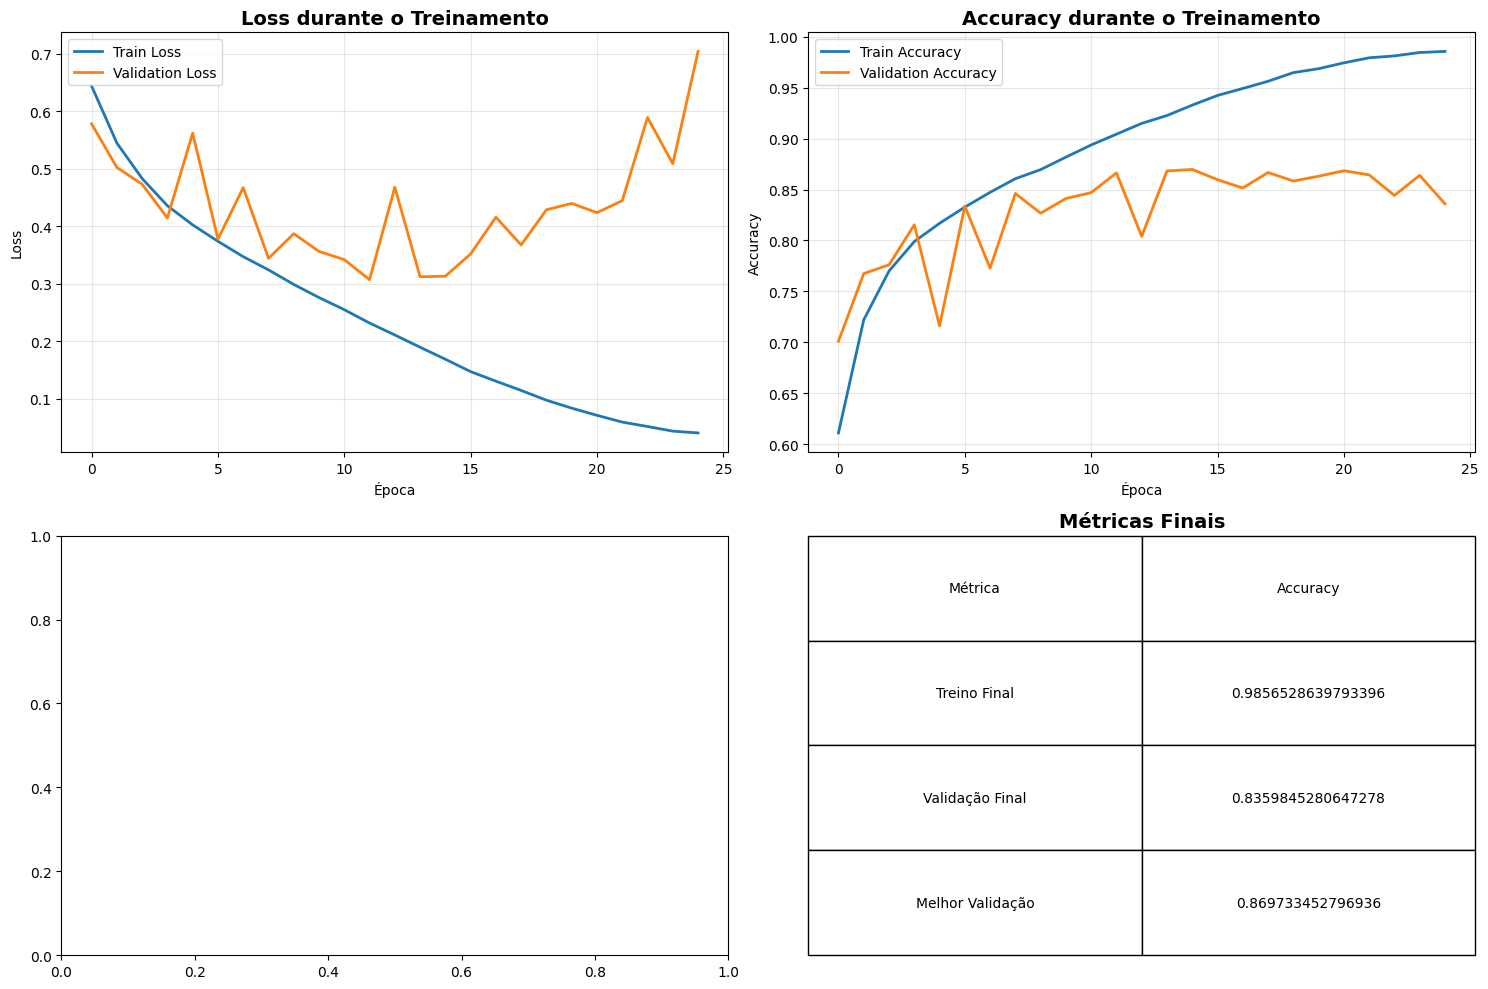


📈 AVALIAÇÃO DETALHADA DO MODELO...
📊 Métricas de avaliação:
   - Loss: 0.3133
   - Accuracy: 0.8697

📋 RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

        Gato       0.86      0.87      0.87      2280
    Cachorro       0.88      0.87      0.87      2372

    accuracy                           0.87      4652
   macro avg       0.87      0.87      0.87      4652
weighted avg       0.87      0.87      0.87      4652



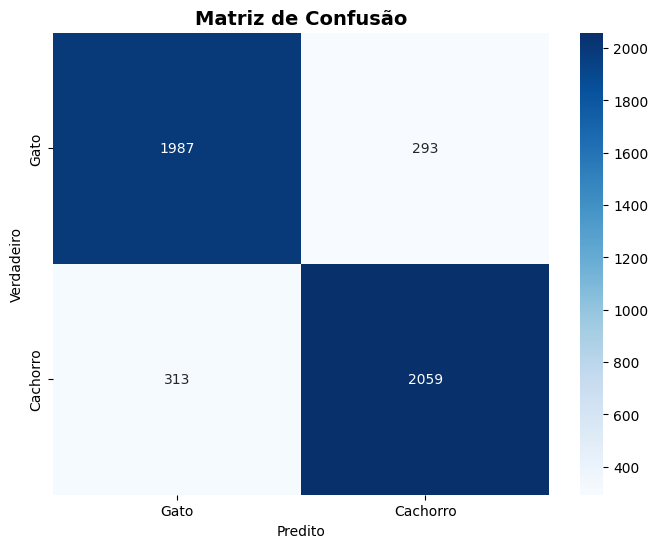


🔍 VISUALIZANDO PREDIÇÕES EM AMOSTRAS...


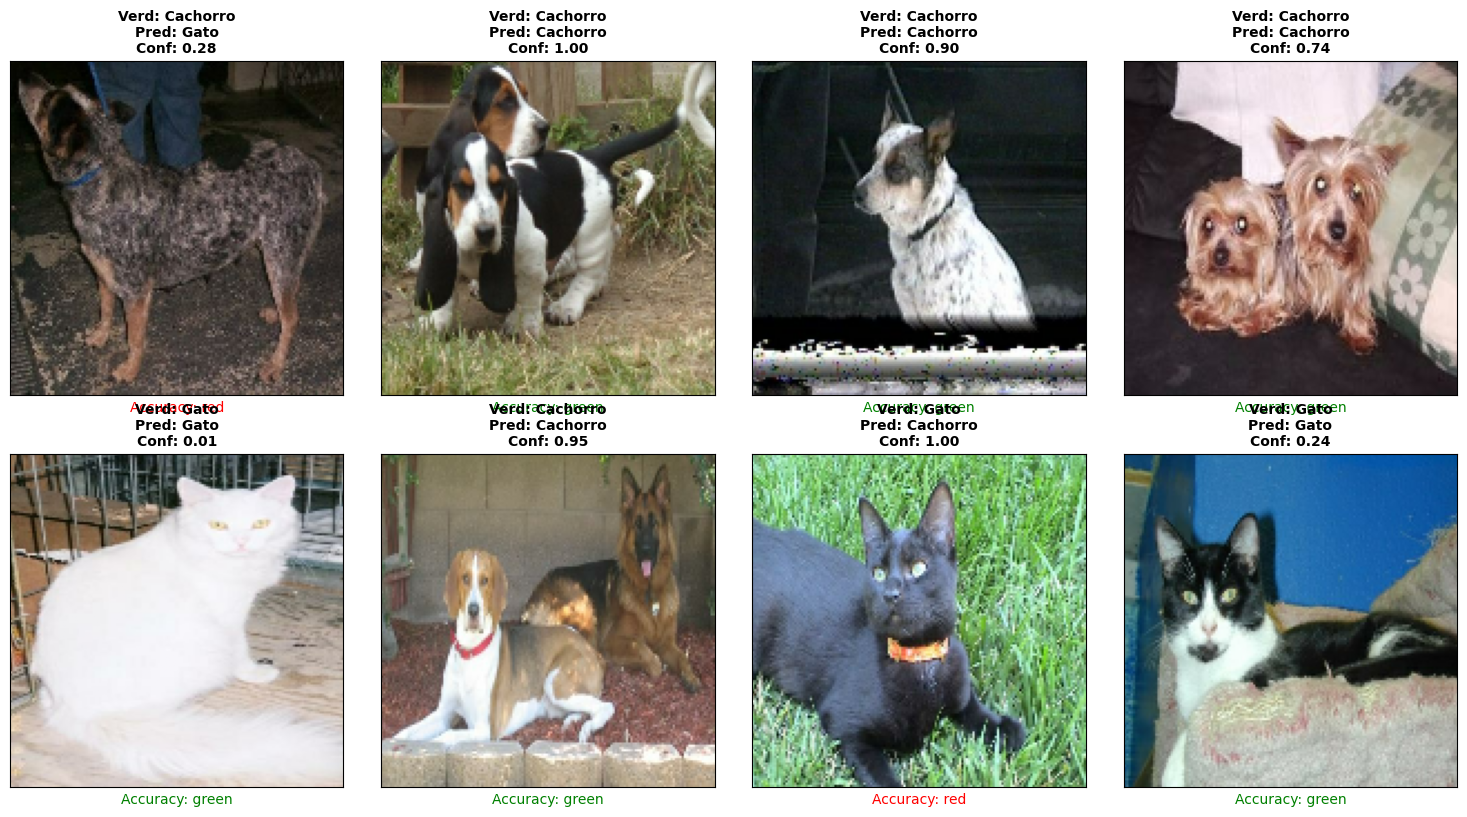


💾 Modelo salvo como 'dogs_vs_cats_cnn.h5'

🔍 TESTANDO CLASSIFICAÇÃO...


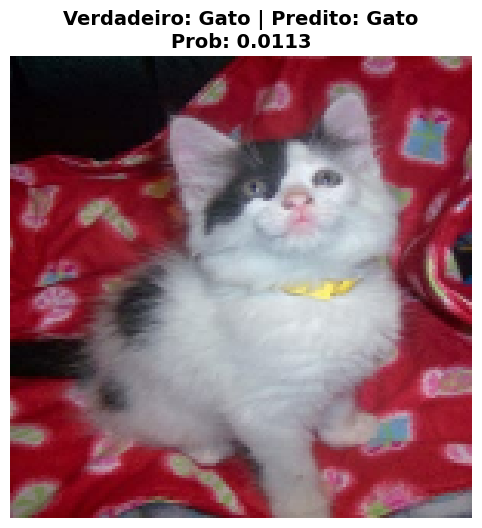


🎉 PROGRAMA CONCLUÍDO COM SUCESSO!
📈 Melhor accuracy de validação: 86.97%
💾 Modelo salvo: 'dogs_vs_cats_cnn.h5'
🔮 Para classificar novas imagens, use a função classify_new_image()

📝 EXEMPLO DE USO PARA NOVAS IMAGENS:

    # Carregar modelo treinado
    model = keras.models.load_model('dogs_vs_cats_cnn.h5')
    
    # Classificar nova imagem
    classify_new_image(model, 'caminho/para/sua/imagem.jpg')
    


In [11]:
# 10. EXECUÇÃO DO PROGRAMA
if __name__ == "__main__":
    # Instalação automática de dependências (se necessário)
    try:
        import tensorflow_datasets as tfds
    except ImportError:
        print("📦 Instalando dependências necessárias...")
        os.system("pip install tensorflow-datasets matplotlib seaborn pandas")
        import tensorflow_datasets as tfds

    # Executar programa principal
    main()

    # Exemplo de como usar a classificação depois do treinamento
    print("\n📝 EXEMPLO DE USO PARA NOVAS IMAGENS:")
    print("""
    # Carregar modelo treinado
    model = keras.models.load_model('dogs_vs_cats_cnn.h5')

    # Classificar nova imagem
    classify_new_image(model, 'caminho/para/sua/imagem.jpg')
    """)